## 1. Chargement des données
[RoBERTA-Text-Classification](https://jesusleal.io/2020/10/20/RoBERTA-Text-Classification/) \
<https://youtu.be/vNKIg8rXK6w>

In [39]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from itertools import cycle
from transformers import RobertaForTokenClassification, TrainingArguments, Trainer
import re


In [9]:
# Chargement du dataset brut
raw_df = pd.read_csv("data/adresses-france.csv/adresses-france.csv", sep=";", dtype=object, usecols=['numero', 'rep', 'nom_voie', 'code_postal', 'nom_commune'])

print("Dataset initial (5 premières lignes):")
display(raw_df.head())

Dataset initial (5 premières lignes):


,numero,rep,nom_voie,code_postal,nom_commune
0,630,NaN,la Chèvre,01400,L'Abergement-Clémenciat
1,108,NaN,Clemencia,01400,L'Abergement-Clémenciat
2,9,NaN,Imp des Epis,01400,L'Abergement-Clémenciat
3,23,NaN,Imp des Epis,01400,L'Abergement-Clémenciat
4,26,NaN,Imp des Epis,01400,L'Abergement-Clémenciat


In [10]:
nombre_lignes = raw_df.shape[0]
nombre_colonnes = raw_df.shape[1]
taille = raw_df.size

# Affichage des résultats
print(f"Nombre de lignes : {nombre_lignes}")
print(f"Nombre de colonnes : {nombre_colonnes}")
print(f"Taille totale : {taille}")

Nombre de lignes : 26032916
Nombre de colonnes : 5
Taille totale : 130164580


## 2. Sélection et renommage des colonnes

Je veux que ma base de données contienne au minimum tous les codes postaux et tous les rep. Car ce sont les plus rares.

In [43]:
df = raw_df.copy()

# Sélection des combinaisons uniques de 'code_postal'
df1 = df.drop_duplicates(subset=['code_postal'])

# Sélection des combinaisons uniques de 'rep'
df2 = df.drop_duplicates(subset=['rep'])

# Sélection des combinaisons uniques de 'numero'
df3 = df.drop_duplicates(subset=['numero'])

# Conserver le 1/5 ième inférieur
df3 = df3.iloc[:len(df3) // 5].reset_index(drop=True)

# Concaténation des deux bases de données et suppression des doublons
df_final = pd.concat([df1, df2, df3]).drop_duplicates().reset_index(drop=True)
df = df_final.rename(columns={'nom_commune': 'ville'})

# Réorganisation des colonnes
df = df[['numero', 'rep', 'nom_voie', 'code_postal', 'ville']]

def add_na_no_overlap(data, column, missing_percentage=0.1):
    num_missing = int(len(data) * missing_percentage)
    missing_indices = np.random.choice(data.index, size=num_missing, replace=False)
    data.loc[missing_indices, column] = np.nan
    return data

# Appliquer l'ajout de NaN à 10% dans la colonne 'numero' du DataFrame original
df = add_na_no_overlap(df, 'numero', 0.005)

# Appliquer l'ajout de NaN à 10% dans 'ville' uniquement pour les lignes où 'numero' n'est pas NaN
df.loc[df['numero'].notna(), 'ville'] = df.loc[df['numero'].notna(), 'ville'].apply(lambda x: np.nan if np.random.rand() < 0.005 else x)

# Appliquer l'ajout de NaN à 10% dans 'code_postal' uniquement pour les lignes où 'numero' et 'ville' ne sont pas NaN
df.loc[df['numero'].notna() & df['ville'].notna(), 'code_postal'] = df.loc[df['numero'].notna() & df['ville'].notna(), 'code_postal'].apply(lambda x: np.nan if np.random.rand() < 0.005 else x)

df = df.fillna('')

In [44]:
display(df.head(10))

,numero,rep,nom_voie,code_postal,ville
0,630,,la Chèvre,01400,L'Abergement-Clémenciat
1,6,,Place du Pese Lait,01640,L'Abergement-de-Varey
2,63,,le Buisson,01330,Ambérieux-en-Dombes
3,2,,Lotissement le Nan,01500,Ambérieu-en-Bugey
4,1,,Rue des Collonges,01350,Vongnes
5,17,,Les Hauts de Virignin,01300,Virignin
6,1,,Bergon,01260,Arvière-en-Valromey
7,2,,Rue des Barmettes,01510,Arvière-en-Valromey
8,2,,Route de Neuville les Dames,01540,Vonnas
9,1,,Rue Andre Charles Boulle,01440,Viriat


Dans la constitution de ma base de données, j'ai ainsi reproduit les cas où il manque un numéro de rue, le nom de la rue, le code postal ou le `rep`. Afin de m'adapter à différents cas de figure

In [45]:
nombre_lignes = df.shape[0]
nombre_colonnes = df.shape[1]
taille = df.size

# Affichage des résultats
print(f"Nombre de lignes : {nombre_lignes}")
print(f"Nombre de colonnes : {nombre_colonnes}")
print(f"Taille totale : {taille}")


Nombre de lignes : 11594
Nombre de colonnes : 5
Taille totale : 57970


## 3. Création des labels
Je veux les ordonner dans un ordre spécifique. Bien évidemment, le premier label sera le `numéro`, ensuite dans lordre le second `rep`, `nom_voie`, `code_postal` et enfin la `ville`.

In [46]:
def create_labels(row_arg):
    labels = []
    for field in ['numero', 'rep', 'nom_voie', 'code_postal', 'ville']:
        words_str = str(row_arg[field]) if pd.notna(row_arg[field]) else ''
        words = words_str.split()
        labels.extend([field] * len(words))
    return labels

df['address'] = df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df['words'] = df['address'].str.split()
df['labels'] = df.apply(create_labels, axis=1)
df = df[['address', 'words', 'labels']].copy()


In [47]:
# Vérifier l'alignement mots/labels
for i, row in df.iterrows():
    assert len(row['words']) == len(row['labels']), f"Erreur ligne {i}"

# Vérifier les types
assert df['words'].apply(type).eq(list).all()
assert df['labels'].apply(type).eq(list).all()

# Vérifier les valeurs manquantes
print("Valeurs manquantes:")
print(df.isna().sum())

Valeurs manquantes:
address    0
words      0
labels     0
dtype: int64


## 4. Conversion en Dataset Hugging Face
Pour entraîner notre modèle, il nous faut convertir notre base de données en un format utilisable par le modèle.

In [48]:
from datasets import Dataset
df_for_recostitution = df
dataset = Dataset.from_pandas(df)
print("Exemple d'entrée dataset:")
def display_dataset(data, n=3):
    """Affiche les n premières et n dernières entrées du dataset de manière lisible."""

    total_entries = len(data["address"])
    indices = list(range(n)) + list(range(max(n, total_entries - n), total_entries))  # Indices à afficher

    for indice in indices:
        print(f"Entrée {indice + 1}:")
        print(f"  Adresse : {data['address'][indice]}")
        print(f"  Mots    : {', '.join(data['words'][indice])}")
        print(f"  Labels  : {', '.join(data['labels'][indice])}")
        print("-" * 50)

display_dataset(dataset, n=5)


Exemple d'entrée dataset:
Entrée 1:
  Adresse : 630  la Chèvre 01400 L'Abergement-Clémenciat
  Mots    : 630, la, Chèvre, 01400, L'Abergement-Clémenciat
  Labels  : numero, nom_voie, nom_voie, code_postal, ville
--------------------------------------------------
Entrée 2:
  Adresse : 6  Place du Pese Lait 01640 L'Abergement-de-Varey
  Mots    : 6, Place, du, Pese, Lait, 01640, L'Abergement-de-Varey
  Labels  : numero, nom_voie, nom_voie, nom_voie, nom_voie, code_postal, ville
--------------------------------------------------
Entrée 3:
  Adresse : 63  le Buisson 01330 Ambérieux-en-Dombes
  Mots    : 63, le, Buisson, 01330, Ambérieux-en-Dombes
  Labels  : numero, nom_voie, nom_voie, code_postal, ville
--------------------------------------------------
Entrée 4:
  Adresse : 2  Lotissement le Nan 01500 Ambérieu-en-Bugey
  Mots    : 2, Lotissement, le, Nan, 01500, Ambérieu-en-Bugey
  Labels  : numero, nom_voie, nom_voie, nom_voie, code_postal, ville
----------------------------------------

## 5. Configuration des labels
Je vais encoder les différents labels

In [49]:
# Réorganiser directement les éléments
ordered_labels = ['numero', 'rep', 'nom_voie', 'code_postal', 'ville']
print(ordered_labels)
# Mapping label -> ID et ID -> label
label2id = {label: i for i, label in enumerate(ordered_labels)}
id2label = {i: label for label, i in label2id.items()}

# Affichage
print("label2id:", label2id)
print("id2label:", id2label)

['numero', 'rep', 'nom_voie', 'code_postal', 'ville']
label2id: {'numero': 0, 'rep': 1, 'nom_voie': 2, 'code_postal': 3, 'ville': 4}
id2label: {0: 'numero', 1: 'rep', 2: 'nom_voie', 3: 'code_postal', 4: 'ville'}


## 6. Tokenization

In [50]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)

def tokenize_and_align_labels(examples):
    # Conversion des étiquettes en IDs
    labels_encoded = [list(map(label2id.get, lbl_list)) for lbl_list in examples["labels"]]

    # Tokenisation des mots
    tokenized_inputs = tokenizer(
        examples["words"],
        truncation=True,
        is_split_into_words=True,
        padding=True,   # Padding dynamique (pas de longueur fixe)
        max_length=18   # Limite de longueur maximale plus large pour les adresses plus longues
    )

    # Alignement des étiquettes avec les tokens
    aligned_labels = []
    for indince, lbls in enumerate(labels_encoded):
        word_ids = tokenized_inputs.word_ids(batch_index=indince)
        token_labels = []

        prev_word_idx = None  # Pour savoir si on est dans le même mot

        for word_idx in word_ids:
            if word_idx is None:
                # Masquage des tokens spéciaux (CLS, SEP, PAD)
                token_labels.append(-100)
            elif word_idx != prev_word_idx:
                # Nouveau mot, attribuer le label du mot entier
                token_labels.append(lbls[word_idx])
            else:
                # Sous-token, attribuer -100 pour ne pas affecter le label
                token_labels.append(-100)
            prev_word_idx = word_idx

        aligned_labels.append(token_labels)

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/11594 [00:00<?, ? examples/s]

In [51]:
print("\nExemple de sortie tokenized:")
print(tokenized_dataset[13])


Exemple de sortie tokenized:
{'address': '1  les Améries 01480 Villeneuve', 'words': ['1', 'les', 'Améries', '01480', 'Villeneuve'], 'labels': [-100, 0, 2, 2, -100, -100, 3, -100, 4, -100, -100, -100, -100, -100, -100, -100, -100, -100], 'input_ids': [0, 112, 7427, 1918, 1140, 4458, 9465, 27018, 7296, 2552, 22258, 2, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]}


## 7. Métrics d'évaluations

In [52]:
# 1. Classe de calcul de métriques personnalisées
class MetricsCalculator:
    def __init__(self, id2label_arg):
        self.id2label = id2label_arg
        self.all_labels = []
        self.all_preds = []
        self.all_probs = []

    def add_batch(self, logits, labels):
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        preds = np.argmax(logits, axis=-1)

        # Filtrer les labels ignorés (-100)
        mask = labels != -100
        for prob, pred, label, m in zip(probs, preds, labels, mask):
            valid = m.nonzero()[0]
            self.all_probs.extend(prob[valid])
            self.all_preds.extend(pred[valid])
            self.all_labels.extend(label[valid])

    def compute(self):
        # Classification report
        report = classification_report(
            self.all_labels,
            self.all_preds,
            target_names=list(self.id2label.values()),
            zero_division=0
        )

        # Matrice de confusion
        cm = confusion_matrix(self.all_labels, self.all_preds)

        # Courbe ROC et AUC
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = len(self.id2label)

        # Binarize les labels pour le multiclass
        y_true = np.eye(n_classes)[self.all_labels]
        y_score = np.array(self.all_probs)

        for indice in range(n_classes):
            fpr[indice], tpr[indice], _ = roc_curve(y_true[:, indice], y_score[:, indice])
            roc_auc[indice] = auc(fpr[indice], tpr[indice])

        # Micro-average
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        return {
            "report": report,
            "confusion_matrix": cm,
            "roc_auc": roc_auc,
            "fpr": fpr,
            "tpr": tpr
        }


    # 2. Intégration dans le Trainer
def compute_metrics(p):
    metric_calculator = MetricsCalculator(id2label)
    metric_calculator.add_batch(p.predictions, p.label_ids)
    metrics = metric_calculator.compute()

    # Affichage des métriques
    print("Classification Report:\n", metrics["report"])

    # Matrice de confusion normalisée
    cm = metrics["confusion_matrix"].astype('float') / metrics["confusion_matrix"].sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=id2label.values(), yticklabels=id2label.values())
    plt.title("Matrice de confusion normalisée")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies étiquettes")
    plt.show()

    # Courbes ROC
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for indice, color in zip(range(len(id2label)), colors):
        plt.plot(metrics["fpr"][indice], metrics["tpr"][indice], color=color,
                 label='ROC {0} (AUC = {1:0.2f})'.format(id2label[indice], metrics["roc_auc"][indice]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbes ROC par classe')
    plt.legend(loc="lower right")
    plt.show()

    return {
        "overall_accuracy": np.mean(np.array(metrics["all_preds"]) == np.array(metrics["all_labels"])),
        "macro_auc": np.mean(list(metrics["roc_auc"].values()))
    }

## 8. Paramètres du modèle

In [53]:
model = RobertaForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate= 5e-5,
    per_device_train_batch_size=4,
    num_train_epochs=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=1000
)


# 7. Création du Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
    compute_metrics=compute_metrics
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ce message rouge veut dire que des **poids** et **biais** de la couche de classification sont nouvellement initialisés, car ces paramètres ne faisaient pas partie du modèle de base `roberta-base`. Ils sont créés au moment de l'initialisation du modèle pour la tâche de classification spécifique.

### Que faire ?
Il faut donc **entraîner le modèle** pour que ces poids nouvellement initialisés aient un sens et puissent être utilisés pour des prédictions.

### Fine-tuning
Le **fine-tuning** consiste à **optimiser ces nouveaux poids et biais** qui ont été ajustés aux poids déjà présents dans le modèle pré-entrainé. Ce processus permet donc d'adapter le modèle préexistant à une tâche spécifique.

## 9. Entraînement

Epoch,Training Loss,Validation Loss


Classification Report:
               precision    recall  f1-score   support

      numero       1.00      1.00      1.00     11537
         rep       1.00      1.00      1.00      5294
    nom_voie       1.00      1.00      1.00     37563
 code_postal       1.00      1.00      1.00     11415
       ville       1.00      1.00      1.00     11993

    accuracy                           1.00     77802
   macro avg       1.00      1.00      1.00     77802
weighted avg       1.00      1.00      1.00     77802



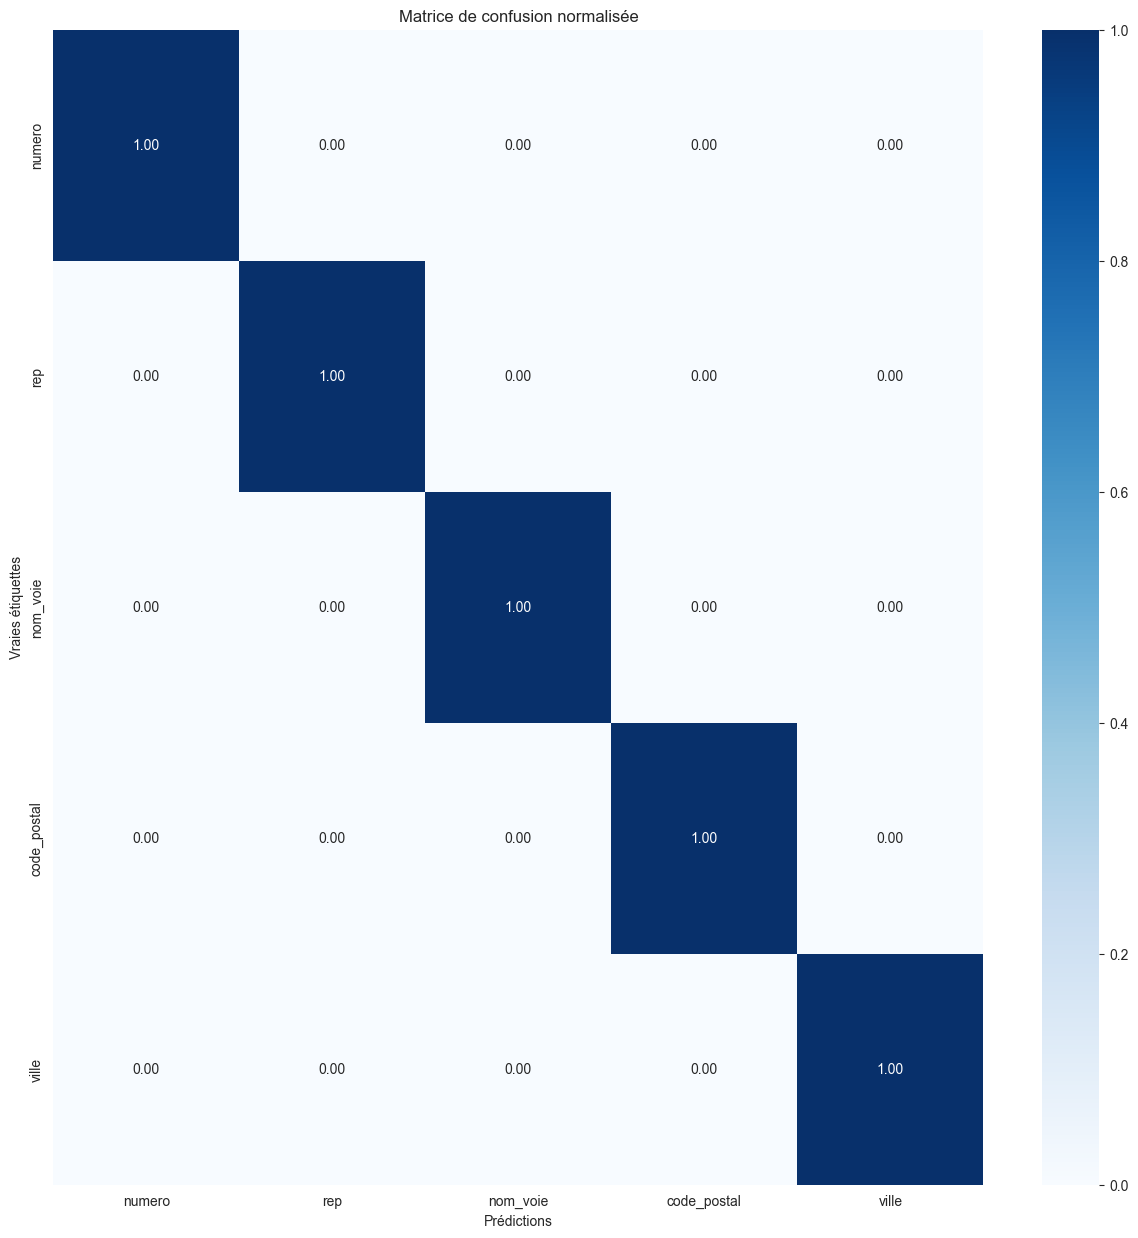

Epoch,Training Loss,Validation Loss


KeyError: 'all_preds'

In [54]:
trainer.train()

## 10. Évaluation finale

Classification Report:
               precision    recall  f1-score   support

      numero       1.00      1.00      1.00     11537
         rep       1.00      1.00      1.00      5294
    nom_voie       1.00      1.00      1.00     37563
 code_postal       1.00      1.00      1.00     11415
       ville       1.00      1.00      1.00     11993

    accuracy                           1.00     77802
   macro avg       1.00      1.00      1.00     77802
weighted avg       1.00      1.00      1.00     77802



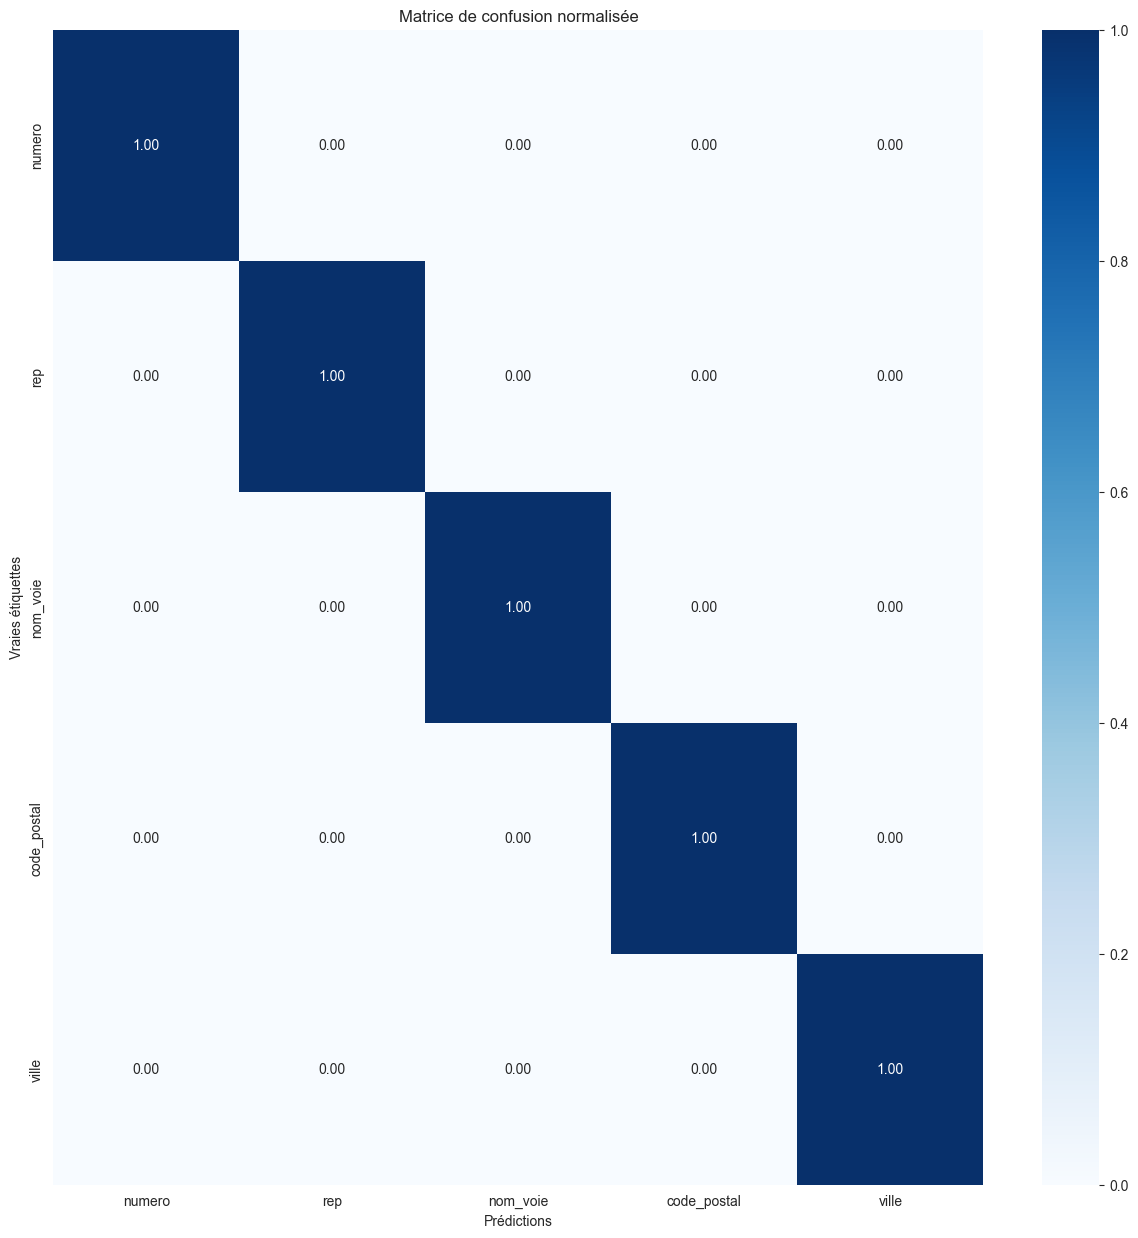

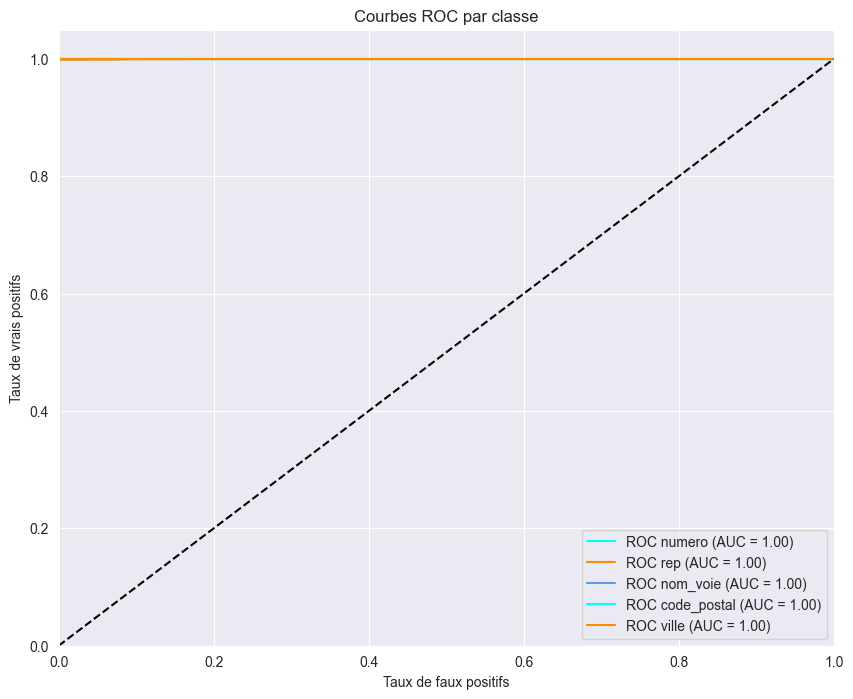

KeyError: 'all_preds'

In [55]:
final_metrics = trainer.evaluate()
print("\nMétriques finales:")
for key, value in final_metrics.items():
    print(f"{key}: {value:.4f}")

## 11. Sauvegarde du modèle

In [57]:
model.save_pretrained("./address_parser2")
tokenizer.save_pretrained("./address_parser2")

('./address_parser2\\tokenizer_config.json',
 './address_parser2\\special_tokens_map.json',
 './address_parser2\\vocab.json',
 './address_parser2\\merges.txt',
 './address_parser2\\added_tokens.json',
 './address_parser2\\tokenizer.json')

In [58]:
print(model.state_dict()['classifier.weight'])  # Doit montrer des valeurs non-nulles

tensor([[ 0.0045,  0.0168,  0.0035,  ...,  0.0171, -0.0198,  0.0267],
        [ 0.0110, -0.0153,  0.0244,  ...,  0.0087,  0.0277,  0.0002],
        [ 0.0245,  0.0009, -0.0057,  ..., -0.0125,  0.0178, -0.0069],
        [ 0.0276, -0.0171, -0.0217,  ..., -0.0141, -0.0259,  0.0108],
        [ 0.0181, -0.0154, -0.0456,  ..., -0.0001, -0.0034,  0.0178]])


In [59]:
print(model.state_dict()['classifier.bias'])

tensor([-0.0010,  0.0002,  0.0013, -0.0020, -0.0011])


Importation du modèle préentraîné

In [81]:
from transformers import pipeline

# Chargement du modèle entraîné
model = pipeline("token-classification", model="./address_parser2")

Device set to use cpu


In [82]:
# Aucun avertissement ne devrait apparaître si le modèle est correctement entraîné
print(model("LYON"))

[{'entity': 'ville', 'score': np.float32(0.9775439), 'index': 1, 'word': 'ĠL', 'start': 0, 'end': 1}, {'entity': 'nom_voie', 'score': np.float32(0.990914), 'index': 2, 'word': 'Y', 'start': 1, 'end': 2}, {'entity': 'nom_voie', 'score': np.float32(0.96320176), 'index': 3, 'word': 'ON', 'start': 2, 'end': 4}]


## 12. Fonction
Les informations renvoyées par le modèle sont brutes et pas lisibles. Écrivons une fonction qui permet d'afficher cela dans une base de données.

In [83]:

def clean_address(address):
    """Nettoie une adresse en remplaçant les virgules et points-virgules par un espace, 
    puis en réduisant les espaces multiples à un seul."""
    address = re.sub(r'[;,]+', ' ', address)  # Remplace les virgules et points-virgules par un espace
    address = re.sub(r'\s+', ' ', address)  # Réduit les espaces multiples à un seul
    return address.strip()  # Supprime les espaces en début et fin


# Fonction pour extraire les informations d'une adresse
def extract_address_info(adresse):
    # Modèle de sortie avec les informations extraites
    address = clean_address(adresse)
    model_output = model(address)  # Remplacer `model(address)` par votre fonction ou modèle

    # Dictionnaire pour stocker les données extraites
    # Initialiser comme chaîne vide si absent
    extracted_info = {
        "adresse": [address],
        "numero": [""],
        "rep": [""],
        "nom_voie": [""],
        "code_postal": [""],
        "ville": [""],
    }

    # Liste des indices start et end pour chaque champ
    entities = {
        "numero": [],
        "rep": [],
        "nom_voie": [],
        "code_postal": [],
        "ville": [],
    }

    # Extraction des entités et ajout des indices start et end
    for entity in model_output:
        entity_type = entity['entity']
        start = entity['start']
        end = entity['end']

        # Ajouter les indices start et end dans la liste correspondante
        if entity_type in entities:
            entities[entity_type].append((start, end))

    # Traitement des champs pour extraire l'information
    for field, indices in entities.items():
        if indices:
            # Trouver le min start et le max end
            min_start = min(start for start, _ in indices)
            max_end = max(end for _, end in indices)
            # Extraire la portion correspondante de l'adresse
            extracted_info[field][0] = address[min_start:max_end].strip()
        else:
            # Si le champ n'existe pas, laisser la chaîne vide
            extracted_info[field][0] = ""

    # Créer un DataFrame à partir du dictionnaire
    data = pd.DataFrame(extracted_info)

    # Retourner le DataFrame
    return data

def process_address_list(adresse_list):
    """Traite une liste d'adresses et retourne un DataFrame avec les informations extraites."""
    df_list = [extract_address_info(address) for address in adresse_list]
    return pd.concat(df_list, ignore_index=True)



## 13. Exemple d'utilisation

In [98]:
df = extract_address_info("28 place des pavillons Lyon")
display(df)

,adresse,numero,rep,nom_voie,code_postal,ville
0,28 place des pavillons Lyon,28,,place des pavillons,,Lyon


In [89]:
# Exemple d'utilisation
address_list = [
    "79   bis  rue de la martyrs, LYON",
    "10, rue des Lilas  75015  Paris",
    "5 Avenue   de la République   Marseille"
]

df = process_address_list(address_list)
display(df)

,adresse,numero,rep,nom_voie,code_postal,ville
0,79 bis rue de la martyrs LYON,79,bis,rue de la martyrs,,LYON
1,10 rue des Lilas 75015 Paris,10,,rue des Lilas,75015,Paris
2,5 Avenue de la République Marseille,5,,Avenue de la République,,Marseille


L'objectif est maintenant de reconstituer la base d'origine en utilisant uniquement la variable **adresse**

In [92]:
display(df_for_recostitution[['address']].head(10))

,address
0,630 la Chèvre 01400 L'Abergement-Clémenciat
1,6 Place du Pese Lait 01640 L'Abergement-de-Varey
2,63 le Buisson 01330 Ambérieux-en-Dombes
3,2 Lotissement le Nan 01500 Ambérieu-en-Bugey
4,1 Rue des Collonges 01350 Vongnes
5,17 Les Hauts de Virignin 01300 Virignin
6,1 Bergon 01260 Arvière-en-Valromey
7,2 Rue des Barmettes 01510 Arvière-en-Valromey
8,2 Route de Neuville les Dames 01540 Vonnas
9,1 Rue Andre Charles Boulle 01440 Viriat


In [93]:
df = process_address_list(df_for_recostitution['address'].head(10).tolist())
display(df)

,adresse,numero,rep,nom_voie,code_postal,ville
0,630 la Chèvre 01400 L'Abergement-Clémenciat,630,,la Chèvre,01400,L'Abergement-Clémenciat
1,6 Place du Pese Lait 01640 L'Abergement-de-Varey,6,,Place du Pese Lait,01640,L'Abergement-de-Varey
2,63 le Buisson 01330 Ambérieux-en-Dombes,63,,le Buisson,01330,Ambérieux-en-Dombes
3,2 Lotissement le Nan 01500 Ambérieu-en-Bugey,2,,Lotissement le Nan,01500,Ambérieu-en-Bugey
4,1 Rue des Collonges 01350 Vongnes,1,,Rue des Collonges,01350,Vongnes
5,17 Les Hauts de Virignin 01300 Virignin,17,,Les Hauts de Virignin,01300,Virignin
6,1 Bergon 01260 Arvière-en-Valromey,1,,Bergon,01260,Arvière-en-Valromey
7,2 Rue des Barmettes 01510 Arvière-en-Valromey,2,,Rue des Barmettes,01510,Arvière-en-Valromey
8,2 Route de Neuville les Dames 01540 Vonnas,2,,Route de Neuville les Dames,01540,Vonnas
9,1 Rue Andre Charles Boulle 01440 Viriat,1,,Rue Andre Charles Boulle,01440,Viriat
